In [1]:
# Импортируем требуемые библиотеки
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_yandex_file(public_key):
    '''Функция загрузки файл с Яндекс.Диска. На вход функции подается ссылка на файл, 
    в резульате получаем скачанный файл в формате csv'''
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key = public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return (download_url)

In [29]:
# Загружаем файлы и сохраняем их
assessments = pd.read_csv(get_yandex_file('https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'))
courses = pd.read_csv(get_yandex_file('https://disk.yandex.ru/d/jmJxR8yhwCXlaw'))
students = pd.read_csv(get_yandex_file('https://disk.yandex.ru/d/DYd4M5b_8RETsA'))
registration = pd.read_csv(get_yandex_file('https://disk.yandex.ru/d/lqHnH8NOZ458iw'))

# Предварительный анализ данных

Для всех датасетов проверяю корректность типов данных, наличие дублей, пустых строк

In [4]:
assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

In [5]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

Замечаем, что имеется 11 строк без даты

In [6]:
duplicateRows = assessments[assessments.duplicated()]
duplicateRows

,code_module,code_presentation,id_assessment,assessment_type,date,weight


In [7]:
courses.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

In [9]:
courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [7]:
duplicateRows = courses[courses.duplicated()]
duplicateRows

,code_module,code_presentation,module_presentation_length


In [20]:
students.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

In [21]:
students.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [22]:
duplicateRows = students[students.duplicated()]
duplicateRows

,id_assessment,id_student,date_submitted,is_banked,score


In [12]:
registration.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

In [13]:
registration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [14]:
duplicateRows = registration[registration.duplicated()]
duplicateRows

,code_module,code_presentation,id_student,date_registration,date_unregistration


Замечаем, что имеется 45 строк без даты регистрации. Пустое поле date_unregistration означает, чтостудент окончил курс

Сначала проанализируем данные и поймем, что считается курсом. 
Предположим, что курс - это предмет, который оканчивается экзаменом и проходит в определенный семестр.
Для анализа возьмем три таблицы: assessments, courses и students. Объединим их в одну.

In [8]:
courses_analysis = pd.merge(assessments, students, on = ['id_assessment'])
number_exams = (courses_analysis.groupby(['id_student', 'code_module', 'assessment_type'], as_index = False)\
                                  .agg({'id_assessment': 'count'})
                                  .query('assessment_type == "Exam"')\
                                  .sort_values('id_assessment', ascending = False))
number_exams.head()

,id_student,code_module,assessment_type,id_assessment
14048,540758,DDD,Exam,2
23363,593903,DDD,Exam,2
12577,527323,DDD,Exam,2
25990,605118,DDD,Exam,2
30146,626407,CCC,Exam,1


Получается, что теория подтверждается и на каждый курс приходится по 1 экзамену. Но есть 4 случая с 2 экзаменами посмотрим 
на них подробнее. Проверим код семестра, даты и оценки

In [9]:
two_exams = (courses_analysis.query('id_student in (540758, 593903, 527323, 605118) & code_module == "DDD" & assessment_type=="Exam"')\
                           .sort_values('id_student'))
two_exams

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
75180,DDD,2013B,25340,Exam,240.0,100.0,527323,229,0,24.0
87566,DDD,2014B,25361,Exam,241.0,100.0,527323,234,0,18.0
75235,DDD,2013B,25340,Exam,240.0,100.0,540758,229,0,40.0
87573,DDD,2014B,25361,Exam,241.0,100.0,540758,234,0,60.0
82731,DDD,2013J,25354,Exam,261.0,100.0,593903,241,0,49.0
95711,DDD,2014J,25368,Exam,NaN,100.0,593903,243,0,44.0
82844,DDD,2013J,25354,Exam,261.0,100.0,605118,237,0,42.0
95749,DDD,2014J,25368,Exam,NaN,100.0,605118,243,0,64.0


Получается, что эти студенты сдавали экзамен в разные семестры. 
#### Значит, мы можем принять теорию, что курс - это предмет, который оканчивается экзаменом и проходит в определенный семестр. 
Также видно, что у курсов с одинаковым предметом и одинаковым семестром один id_assessment, что может быть их идентификатором. Посмотрим, какие курсы и за какие семестры, у нас встречаются в таблице:

In [10]:
courses = (courses_analysis.query('assessment_type == "Exam"')\
                         .groupby(['code_module', 'code_presentation'], as_index = False)\
                         .agg({'id_student': 'count'})\
                         .sort_values('code_module'))
courses                                         

,code_module,code_presentation,id_student
0,CCC,2014B,747
1,CCC,2014J,1168
2,DDD,2013B,602
3,DDD,2013J,968
4,DDD,2014B,524
5,DDD,2014J,950


# Первое задание 
Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) 

In [12]:
# Объединяем файлы assessments и students
students_assessments = pd.merge(students, assessments, on = 'id_assessment')
# Проверяем, что объединение прошло успешно
print(students_assessments.head())
# Также проверим таблицу на пустые строки:
print(students_assessments.isna().sum())

   id_assessment  id_student  date_submitted  is_banked  score code_module  \
0           1752       11391              18          0   78.0         AAA   
1           1752       28400              22          0   70.0         AAA   
2           1752       31604              17          0   72.0         AAA   
3           1752       32885              26          0   69.0         AAA   
4           1752       38053              19          0   79.0         AAA   

  code_presentation assessment_type  date  weight  
0             2013J             TMA  19.0    10.0  
1             2013J             TMA  19.0    10.0  
2             2013J             TMA  19.0    10.0  
3             2013J             TMA  19.0    10.0  
4             2013J             TMA  19.0    10.0  
id_assessment           0
id_student              0
date_submitted          0
is_banked               0
score                 173
code_module             0
code_presentation       0
assessment_type         0
date       

In [13]:
# Столбец date нам для  расчетов не потребуется, эти пустые данные можно оставить, а строки, где нет оценки можно удалить:
students_assessments.dropna(subset = ['score'], inplace = True)

Выбираем только экзамены и только с баллом выше или = 40, т.к. это является критерием успешной сдачи. 
Далее групперуем по студентам и для каждого студента считаем кол-во экзаменов. Выбираем только тех, у которых успешно сдан 1 экзамен и смотрим, сколько таких получилось. 

In [14]:
success_one = (students_assessments.query('assessment_type == "Exam" & score >= 40')\
                      .groupby('id_student')\
                      .agg({'code_module': 'count'})\
                      .query('code_module == 1')\
                      .sort_values('code_module', ascending = False)\
                      .shape)
success_one

(3802, 1)

# Ответ на 1 задание - 3802 студента.
Если человек прошел один предмет несколько раз, то считается, что он закончил несколько курсов

# Задание 2. 
Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (5 баллов)

Для решения потребуется объединить 2 таблицы assessments и students, у нас есть уже готовая таблица students_assessments 
c удаленными пустыми строками.
Посчитаем полное количество студентов, сдававших экзамен по каждому курсу и запишем их в датафрейм total_exams
Посчитаем количество студентов успешно сдавших экзамен по каждому курсу и запишем их в датафрейм success_exams
Объединим эти две таблицы и найдем долю сдавших от общего количества, запишем результат в колонку final

In [15]:
total_exams = (students_assessments.query('assessment_type == "Exam"')\
                                           .groupby(['id_assessment', 'code_module', 'code_presentation'], as_index = False)\
                                           .agg({'id_student': 'count'}))
success_exams = (students_assessments.query('assessment_type == "Exam"&score >= 40')\
                                           .groupby(['id_assessment', 'code_module', 'code_presentation'], as_index = False)\
                                           .agg({'id_student': 'count'}))
exams_hardness = pd.merge(total_exams, success_exams, on = ['id_assessment', 'code_module', 'code_presentation'])

exams_hardness['final'] = exams_hardness.id_student_y / exams_hardness.id_student_x
print(exams_hardness.sort_values('final'))

   id_assessment code_module code_presentation  id_student_x  id_student_y  \
2          25340         DDD             2013B           602           504   
1          24299         CCC             2014J          1168          1019   
5          25368         DDD             2014J           950           842   
0          24290         CCC             2014B           747           664   
3          25354         DDD             2013J           968           878   
4          25361         DDD             2014B           524           485   

      final  
2  0.837209  
1  0.872432  
5  0.886316  
0  0.888889  
3  0.907025  
4  0.925573  


# Ответ на 2 задание: Самый легкий курс - DDD в семестре 2014В. Самый сложный - DDD в семестре 2013B.

# Задание 3. 
По каждому предмету определи средний срок сдачи экзаменов 
(под сдачей понимаем последнее успешное прохождение экзамена студентом)

Для этого задания нам потребуется эта же объединенная таблица students_assessments с удаленными пустыми строками.
Посчитаем финальную дату сдачи предмета для каждого студента и проверим, что получилось:

In [16]:
tests_dates = (students_assessments.query('assessment_type == "Exam"&score >= 40')\
                                 .groupby(['code_module', 'id_student'], as_index = False)\
                                 .agg({'date_submitted': 'max'}))
tests_dates

,code_module,id_student,date_submitted
0,CCC,23698,243
1,CCC,27116,243
2,CCC,28787,243
3,CCC,29420,244
4,CCC,29639,248
...,...,...,...
4384,DDD,2693243,230
4385,DDD,2694886,236
4386,DDD,2694933,230
4387,DDD,2695608,237


In [18]:
# Далее найдем среднее по каждому предмету:
mean_tests_dates = tests_dates.groupby('code_module', as_index = False).agg({'date_submitted': 'mean'})
mean_tests_dates
# Ответ на третье задание в получившейся таблице:

,code_module,date_submitted
0,CCC,239.345217
1,DDD,237.978566


# Ответ на третье задание в получившейся таблице:
code_module	date_submitted
0	CCC	     239.345217
1	DDD	     237.978566

# Задание 4. 
Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. 
А также предметы с самым большим оттоком (ТОП-3). 

In [19]:
# Для решения этого задания потребуется таблица registration. Проверим, есть ли в ней пустые данные:
registration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [30]:
# Удалим строки без дат регистрации:
registration.dropna(subset = ['date_registration'], inplace = True)

Сначала определим предметы с максимумо регистраций.
Посчитаем 2 варианта: 1) если регистрация была в дальнейшем отменена, она не считается. 2) все регистрации в целом
 1. Только неотмененные регистрации:

In [31]:
registration['date_unregistration'] = registration.date_unregistration.isna()

registration_number = (registration.query('date_unregistration == True')\
                                 .groupby('code_module', as_index = False)\
                                 .agg({'id_student': 'nunique'})
                                  .sort_values('id_student', ascending = False))
registration_number

,code_module,id_student
1,BBB,5511
5,FFF,5355
3,DDD,4007
2,CCC,2486
6,GGG,2244
4,EEE,2209
0,AAA,620


2. Все регистрации:

In [32]:
registration_full = (registration.groupby('code_module', as_index = False)\
                               .agg({'id_student': 'nunique'})
                                .sort_values('id_student', ascending = False))
registration_full

,code_module,id_student
1,BBB,7683
5,FFF,7387
3,DDD,5840
2,CCC,4244
4,EEE,2858
6,GGG,2525
0,AAA,712


In [33]:
# Теперь найдем для каждого предмета долю отмененных регистраций

registration_cancelled = pd.merge(registration_full, registration_number, on = 'code_module')
registration_cancelled['cancelled'] = (registration_cancelled.id_student_y / registration_cancelled.id_student_x)
print(registration_cancelled.sort_values('cancelled', ascending = False))

  code_module  id_student_x  id_student_y  cancelled
5         GGG          2525          2244   0.888713
6         AAA           712           620   0.870787
4         EEE          2858          2209   0.772918
1         FFF          7387          5355   0.724922
0         BBB          7683          5511   0.717298
2         DDD          5840          4007   0.686130
3         CCC          4244          2486   0.585768


# Ответ на 4 задание: 
Вне зависимости, как считать: с учетом отмененных регистраций или без^ 
# ТОП-3 по количеству регистраций: 1.BBB, 2.FFF, 3.DDD
# ТОП-3 по оттоку: 1.GGG, 2.AAA, 3.EEE

# Задание 5. 
Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов 
и самыми долгими средними сроками сдачи курсов.

Для решения задания будем использовать подготовленную ранее таблицу students_assessments. 
Для начала проверим за какой период у нас все имеющиеся данные.

In [34]:
assessments_dates = assessments.groupby('code_presentation').agg({'id_assessment': 'count'})
assessments_dates

,id_assessment
code_presentation,
2013B,39
2013J,53
2014B,57
2014J,57


In [35]:
# Получается данные у нас как раз с начала 2013 по конец 2014.
# Чтобы посчитать средний срок сдачи, для каждого студента нужно оставить только одну финальную дату сдачи.
assessment_success = (students_assessments.query('assessment_type == "Exam" & score >= 40')\
                                        .groupby(['code_presentation', 'id_student'], as_index = False)\
                                        .agg({'date_submitted': 'max'}))
# Посчитаем для каждого курса средний срок сдачи курсов и количество успешно сдавших студентов.
assessment_success = (assessment_success.groupby('code_presentation', as_index=False)\
                                        .agg({'id_student': 'count', 'date_submitted': 'mean'}))
# Чтобы посчитать процент завершаемости, по каждому семестру необходимо найти общее количество студентов:
assessment_full = (students_assessments.query('assessment_type == "Exam"')\
                                     .groupby('code_presentation', as_index = False)\
                                     .agg({'id_student': 'count'}))
assessment_success = pd.merge(assessment_success, assessment_full, on = 'code_presentation')
assessment_success['success_share'] = assessment_success.id_student_x / assessment_success.id_student_y
assessment_success

,code_presentation,id_student_x,date_submitted,id_student_y,success_share
0,2013B,504,230.164683,602,0.837209
1,2013J,878,239.509112,968,0.907025
2,2014B,1140,233.007018,1271,0.896932
3,2014J,1814,243.707277,2118,0.856468


# Ответ на 5 задание: семестр с самой низкой завершаемостью курсов - 2013B. 
# Семестр с самыми долгими средними сроками сдачи курсов -  2014J

# Задание 6. 
Построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию

Сначала для каждого студента определим:
R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен
Объединенные данные в таблице students_assessments. Сначала возьмем только успешные сдачи экзамена. При расчете R будем учитывать время, только успешно сданных экзаменов.
Для каждого студента определим последний день сдачи каждого экзамена.

In [36]:
success_assessments = (students_assessments.query('assessment_type == "Exam" & score >= 40')\
                                         .groupby(['id_student', 'id_assessment'], as_index = False)\
                                         .agg({'date_submitted': 'max'}))
# Далее посчитаем R и кол-во успешно сданных курсов                                         
success_assessments = (success_assessments.groupby('id_student', as_index = False)\
                                         .agg({'date_submitted': 'mean', 'id_assessment': 'count'}))
success_assessments.rename(columns = {'date_submitted': 'R_mean_time', 'id_assessment': 'success_exams'}, inplace = True)
# Посчитаем общее количество курсов каждого студента и среднюю оценку за экзамен, на случай, если экзамен сдавался 
# несколько раз
full_assessments = (students_assessments.query('assessment_type == "Exam"')\
                                      .groupby(['id_student', 'id_assessment'], as_index = False)\
                                      .agg({'score': 'mean'}))

full_assessments = (full_assessments.groupby('id_student', as_index = False)\
                                         .agg({'score': 'mean', 'id_assessment': 'count'}))                                       
# Объединим таблицы.Т.к. могут быть студенты, которые не сдали ни одного экзамена, сделаем Outer join.   
final_assessments=pd.merge(full_assessments, success_assessments, how = 'outer', on = 'id_student')
# Для тех, кто не сдал ни одного экзамена, заполним столбцы кол-во успешных экзаменов и среднее время сдачи  -0
final_assessments['success_exams'] = final_assessments['success_exams'].fillna (0)

final_assessments.id_assessment = final_assessments.success_exams / final_assessments.id_assessment
final_assessments = final_assessments.rename(columns = {'id_assessment': 'F_course_completion', 'score': 'M_mean_score'})
# Готовая таблица для анализа:
final_assessments.head()



,id_student,M_mean_score,F_course_completion,R_mean_time,success_exams
0,23698,80.0,1.0,243.0,1.0
1,24213,58.0,1.0,236.0,1.0
2,27116,96.0,1.0,243.0,1.0
3,28046,40.0,1.0,237.0,1.0
4,28787,44.0,1.0,243.0,1.0


По метрике M мы знаем, что значение лежит в диапазоне от 0 до 100. 
Проверим, какие значения могут принимать у нас метрики F и R:

In [37]:
print(final_assessments.R_mean_time.max(), final_assessments.R_mean_time.min())
# Для несданных экзаменов у нас это поле осталось пустым. Заполним его 0:
final_assessments['R_mean_time'] = final_assessments['R_mean_time'].fillna (0)
F_check = final_assessments.groupby('F_course_completion').agg({'id_student': 'count'})
F_check.head(10)

285.0 229.0


,id_student
F_course_completion,
0.0,536
0.5,28
1.0,4069


Исходя из полученных результатов, определим следующие границы метрик:
#### Метрика F имеет всего 3 ранга: F=0 - 1; F=0.5 - 2; F=1 - 3
#### Для метрики М определим классическую 5-бальную шкалу оценок. Экзамен не сдан M<20, =1;Экзамен не сдан 20<=М<40 =2; Экзамен сдан средне 40<=M<60 =3; Экзамен сдан хорошо 60<=M<80; Экзамен сдан отлично М>=80
Для определения границы R проверим, какие указаны даты сдачи экзаменов для разных семестров:

In [38]:
R_check = assessments.query('(code_module == "DDD" or code_module == "CCC")&assessment_type == "Exam"')
R_check

,code_module,code_presentation,id_assessment,assessment_type,date,weight
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0
87,DDD,2013B,25340,Exam,240.0,100.0
94,DDD,2013J,25354,Exam,261.0,100.0
101,DDD,2014B,25361,Exam,241.0,100.0
108,DDD,2014J,25368,Exam,NaN,100.0


Для большинства экзаменов дата не указана, но за референсное значение можно взять 250 дней. 
#### Для метрики R  выделим 3 категории: экзамены не сданы: R=0 - 1; Экзамены сданы позже средних сроков R>250 - 2; Экзамены сданы раньше средних сроков R<=250 - 3.

In [39]:
# Функции записи в таблицу рангов на основе значений
def r_score(x):
    if x == 0:
        return 1
    elif 0 < x <= 250:
        return 3
    elif x >250:
        return 2
    
def f_score(x):
    if x == 0:
        return 1
    elif x ==0.5:
        return 2
    elif x ==1:
        return 3
    
def m_score(x):
    if x<20:
        return 1
    elif 20 <= x < 40:
        return 2
    elif 40 <= x < 60:
        return 3
    elif 60 <= x < 80:
        return 4
    elif 80 <= x <= 100:
        return 5

Проставим в таблице ранги метрик RFM для каждого студента:

In [40]:
final_assessments['R'] = final_assessments['R_mean_time'].apply(lambda x: r_score(x))
final_assessments['F'] = final_assessments['F_course_completion'].apply(lambda x: f_score(x))
final_assessments['M'] = final_assessments['M_mean_score'].apply(lambda x: m_score(x))
final_assessments['R'] = final_assessments['R'].astype(int)


Посмотрим, какие варианты RFM сегментов получились. И распределение студентов по этим вариантам.

In [41]:
RFM = final_assessments
RFM['RFM_Score'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM = RFM.groupby('RFM_Score', as_index = False).agg({'id_student': 'count'})
print(RFM)

  RFM_Score  id_student
0       111          36
1       112         500
2       233           3
3       234           4
4       235           9
5       322           7
6       323          21
7       333        1240
8       334        1509
9       335        1304


Описание сегментов:
##### 111,112 - Low motivation (Студенты, которые не смогли завершить ни одного курса)
##### 222, 223, 322, 323 - Have potential (Студенты, которые завершили курс со второй попытки или завершили один из двух курсов)
##### 233 - Avg knowledge_high motiv (Cтуденты, которым важно закончить курс, но которым не хватает знаний или которые не хотят глубоко погружаться в тематику)
##### 234,235 - Excl knowledge_need time (Студенты, которые успешно проходят курс, но им для этого требуется больше времени)
##### 333 - Avg knowledge_need time  (Студенты которым не хватает знаний или которые не хотят глубоко погружаться в тематику и при этом тратят много времени на прохождение курса, возможно, им трудно разобраться в теме)
##### 334, 335  - Excl knowledge_high motiv (Студенты, которые на отлично или хорошо знают предмет и вовремя завершают все курсы)

In [42]:
# Определим сегменты в таблице:
segt_map = {
    r'11[1-2]': 'low motivation',
    r'22[2-3]': 'have potential',
    r'233': 'avg knowledge_high motiv',
    r'32[2-3]': 'have potential',
    r'23[4-5]': 'excl knowledge_need time',
    r'333': 'avg knowledge_need time',
    r'33[4-5]': 'excl knowledge_highest motiv'
    }
final_assessments['Segment'] = final_assessments['RFM_Score'].replace(segt_map, regex = True)


Построим графики распределения по каждой метрике и по сегментам.

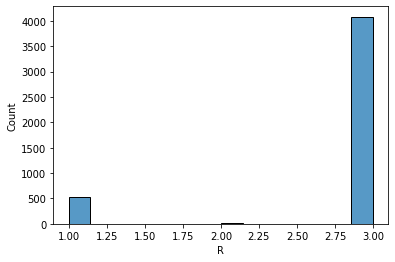

In [43]:
sns.histplot(data = final_assessments, x = 'R')

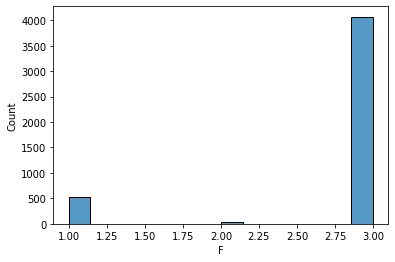

In [44]:
sns.histplot(data = final_assessments, x = 'F')

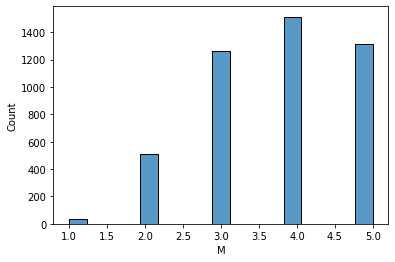

In [45]:
sns.histplot(data = final_assessments, x = 'M')

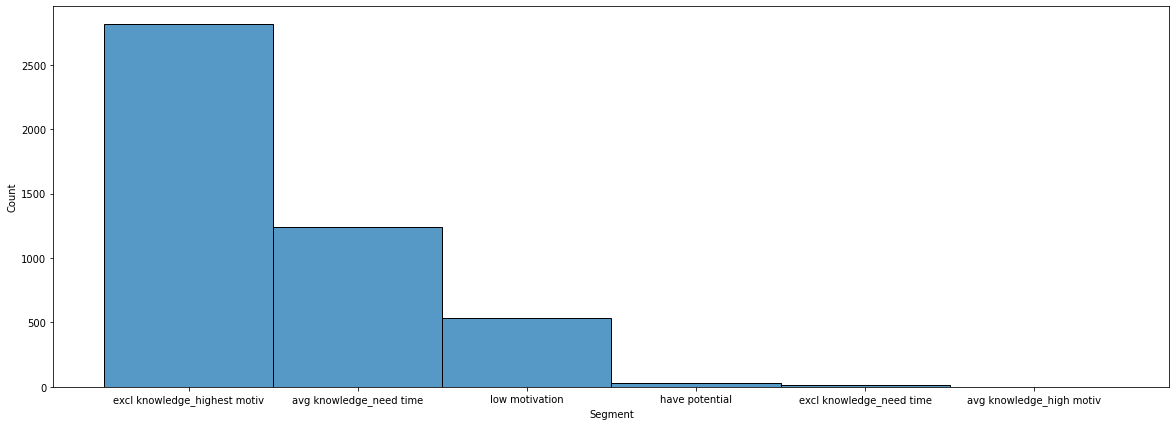

In [46]:
fig, scatter = plt.subplots(figsize = (20, 7))
sns.histplot(data = final_assessments, x = 'Segment')

### На основании графиков мы можем сделать следующие выводы:
1. Большинство студентов заканчивают все курсы вовремя и с высоким баллом
2. Студентам, которые сдают экзамены на низкий балл, требуется на курс больше времени. Т.к. в таблице не было данных о датах сдачи для большинства курсов, вывод сделать сложно. Но можно порекомендовать не ставить жестких дедлайнов и увеличить срок сдачи, чтобы не снижать мотивацию
3. Также мы видим, что достаточно много студентов (примерно 30%) сдают экзамены посредственно, на балл близкий к границе зачета. Стоит проанализировать экзамен и материалы курса подробнее, возможно, какие-то темы вызывают сложности или экзамен составлен некорректно
